In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_squared_error

# 1. Load processed train and test data

In [2]:
train_proc = pd.read_csv("train_proc.csv",sep=',')
test_proc = pd.read_csv("test_proc.csv", sep=',')

In [3]:
print(train_proc.shape)
print(test_proc.shape)

(1460, 284)
(1459, 284)


In [4]:
train_model = train_proc.copy()
y = train_model['SalePrice']
train_model = train_model.drop(['SalePrice', 'Id'], axis=1)
print(train_model.shape)
print(y.shape)

(1460, 282)
(1460,)


## Remove the outliers

In [5]:
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)

In [6]:
# functions to dectect outliers
def find_outliers(model, X, y, sigma=3):
    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    except:
        # if fails, train model first
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
    
    # calculate residules
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    
    # calculate z-statistics, define outliers as |z|>sigma
    z= (resid-mean_resid)/std_resid
    outliers = z[np.abs(z)>sigma].index
    
    # print and plot results
    print("R2 is: ", model.score(X,y))
    print("rmse is: ", rmse(y, y_pred))
    print("-------------------------------")
    
    print("mean of residual is: ", mean_resid)
    print("std of residual is: ", std_resid)
    print("-------------------------------")
    
    print(len(outliers), " outliers.")
    print(outliers.tolist())
    print("-------------------------------")
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y, y_pred, '.')
    plt.plot(y.loc[outliers], y_pred.loc[outliers], 'ro')
    plt.legend(['Included in models','Outliers'])
    plt.xlabel('y')
    plt.ylabel('y_pred')
    
    ax_132 = plt.subplot(1,3,2)
    plt.plot(y, y-y_pred, '.')
    plt.plot(y.loc[outliers], y.loc[outliers] - y_pred.loc[outliers], 'ro')
    plt.legend(['Included in models','Outliers'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred')
    
    ax_133 = plt.subplot(1,3,3)
    z.plot.hist(bins=50, ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50, ax=ax_133)
    plt.legend(['Included in models','Outliers'])
    plt.xlabel('z')
    
    plt.savefig('outliers.png')
    
    return outliers
    
    

R2 is:  0.9387070768251008
rmse is:  0.09885941144174554
-------------------------------
mean of residual is:  -2.1778621524153756e-15
std of residual is:  0.09889328480626251
-------------------------------
19  outliers.
[30, 462, 495, 523, 588, 632, 681, 688, 728, 803, 825, 874, 968, 970, 1298, 1324, 1423, 1432, 1453]
-------------------------------


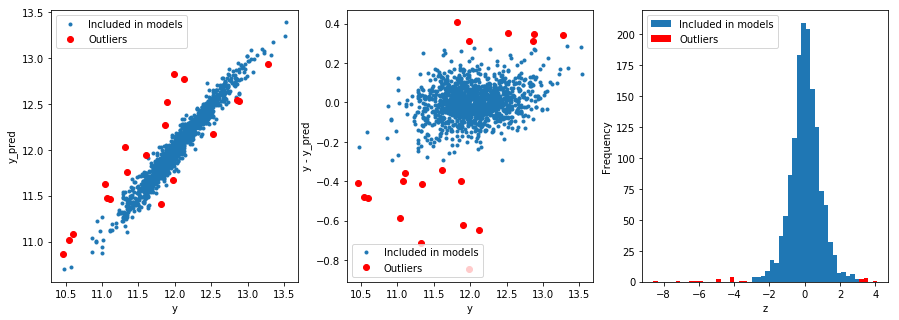

In [7]:
# find and remove outliers using a Ridge model
outliers = find_outliers(Ridge(), train_model, y)

In [8]:
print("Before dropping outliers, train_model has shape",train_model.shape)
print("Before dropping outliers, y has shape", y.shape)
train_model = train_model.drop(outliers)
y = y.drop(outliers)
print("After dropping outliers, train_model has shape",train_model.shape)
print("After dropping outliers, y has shape", y.shape)

Before dropping outliers, train_model has shape (1460, 282)
Before dropping outliers, y has shape (1460,)
After dropping outliers, train_model has shape (1441, 282)
After dropping outliers, y has shape (1441,)


In [17]:
test_model= test_proc.copy()
test_model = test_model.drop('SalePrice', axis=1)
print(test_model.shape)

# test_model_pred = lr.predict(test_model)

# pred = pd.DataFrame(test_model_pred)
# pred.describe()

(1459, 283)


In [ ]:
# flag = train_model.where((train_model>=-3)&(train_model<=3))
# idx = flag.notnull().all(1)
# train_model=train_model[idx]
# y = y[idx]
# print(train_model.shape)
# print(y.shape)
# s1 = train_model.max(axis=0)
# s1 = s1[s1==1]
# s2 = train_model.min(axis=0)
# s2 = s2[s2==0]
# pd.concat([s1,s2],keys=['max','min'], axis=1, sort=True)

# 2. Partition train data and define error measure

In [9]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train_model, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1008, 282)
X_test : (433, 282)
y_train : (1008,)
y_test : (433,)


In [10]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

# 3. Modeling

In [72]:
def plot_resid_pred(y_true, y_pred, model_name):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(y_true, y_true - y_pred, '.')
    plt.title(model_name)
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.legend(loc = "upper left")
    plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
    
    plt.subplot(1,2,2)
    plt.plot(y_true, y_pred, '.')
    plt.title(model_name + ': corr = {:.3f}'.format(np.corrcoef(y_true,y_pred)[0][1]))
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")

### (1) Lasso

In [49]:
alphas = [1, 0.1, 0.001, 0.0005, 0.0001, 0.00005]
model_lasso = LassoCV(alphas = alphas, cv=5, max_iter= 50000, random_state=100).fit(X_train, y_train)

In [51]:
y_train_pred = model_lasso.predict(X_train)
y_test_pred = model_lasso.predict(X_test)

1.00000    0.394030
0.10000    0.206406
0.00100    0.103743
0.00050    0.100441
0.00010    0.101027
0.00005    0.103588
dtype: float64


Text(0.5,1,'rmse of X_train, y_train')

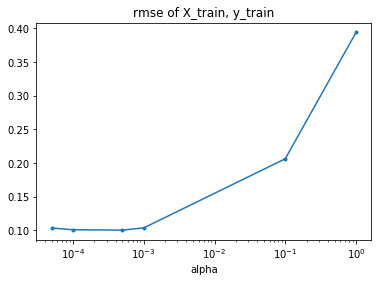

In [57]:
s = pd.Series(np.sqrt(model_lasso.mse_path_).mean(axis=1), index=alphas)
print(s)
s.plot(kind='line', style='.-', logx=True)
plt.xlabel("alpha")
plt.title("rmse of X_train, y_train")

In [87]:
# Method 2 to get the rmse from X_train, y_train
best_rmse_lasso_train = rmse(y_train,y_train_pred)
best_rmse_lasso_test = rmse(y_test, y_test_pred)
print(" the mean rmse from X_train, y_train is : %.3f"%best_rmse_lasso_train)
print(" the mean rmse from X_test, y_test is : %.3f"%best_rmse_lasso_test)
print("R2 is: ", model_lasso.score(X_train,y_train))

 the mean rmse from X_train, y_train is : 0.077
 the mean rmse from X_test, y_test is : 0.100
R2 is:  0.9510624890008144


In [59]:
coef = pd.Series(model_lasso.coef_, index=X_train.columns)
best_alpha_lasso = str(model_lasso.alpha_)
n_del = str(sum(coef==0))
n_keep = str(sum(coef!=0))

print(f"Lasso's best alpha is {best_alpha_lasso}")
print(f"Lasso keeps {n_keep} columns and deleted {n_del} columns")

Lasso's best alpha is 0.0005
Lasso keeps 117 columns and deleted 165 columns


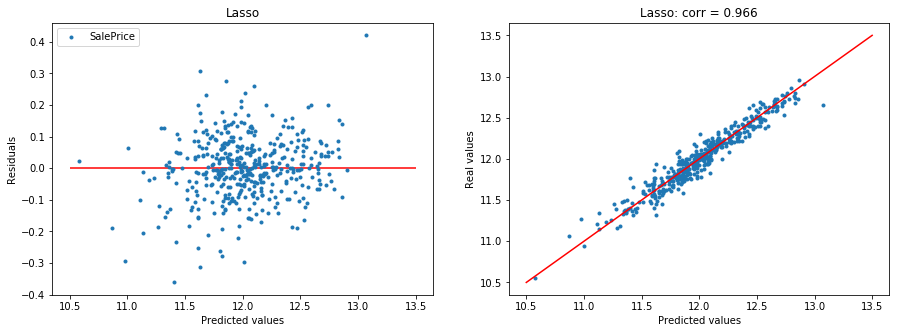

In [74]:
plot_resid_pred(y_test, y_test_pred, "Lasso")

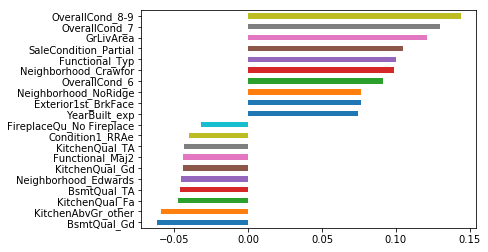

In [75]:
imp_coef_lasso= pd.concat([coef.sort_values().head(10),coef.sort_values().tail(10)])
imp_coef_lasso.plot(kind='barh')

### (2) Ridge

In [76]:
alphas = [0.1, 1, 3, 5, 8, 9, 10,11,12,13,14,15,16,17,100, 1e3, 1e4]
model_ridge = RidgeCV(alphas = alphas, cv=None, store_cv_values=True).fit(X_train, y_train)

In [83]:
best_alpha_ridge= str(model_ridge.alpha_)
print(f"The best alpha for Ridge is {best_alpha_ridge}")

The best alpha for Ridge is 3.0
R2 is:  0.9615485685949132


Text(0.5,1,'Ridge rmse of X_train, y_train')

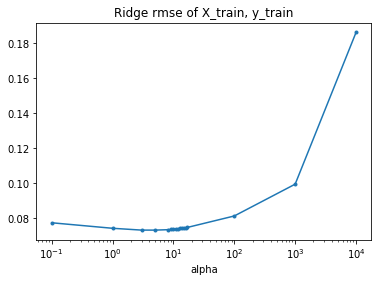

In [81]:
s = pd.Series(np.sqrt(model_ridge.cv_values_).mean(axis=0), index=alphas)
# print(s)
s.plot(kind='line', style='.-', logx=True)
plt.xlabel("alpha")
plt.title("Ridge rmse of X_train, y_train")


 the mean rmse from X_train, y_train is : 0.077
 the mean rmse from X_test, y_test is : 0.100
R2 is:  0.9615485685949132


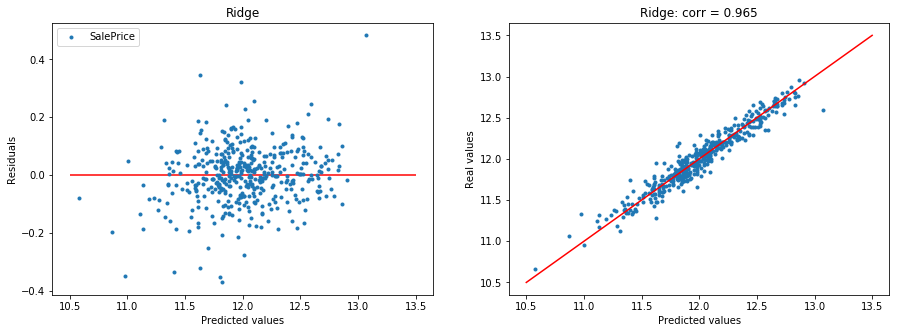

In [101]:
y_train_pred = model_ridge.predict(X_train)
y_test_pred = model_ridge.predict(X_test)

best_rmse_ridge_train = rmse(y_train, y_train_pred)
best_rmse_ridge_test = rmse(y_test, y_test_pred)
print(" the mean rmse from X_train, y_train is : %.3f"%best_rmse_ridge_train)
print(" the mean rmse from X_test, y_test is : %.3f"%best_rmse_ridge_test)
print("R2 is: ", model_ridge.score(X_train,y_train))

plot_resid_pred(y_test, y_test_pred, "Ridge")

In [88]:
coef = pd.Series(model_ridge.coef_, index=X_train.columns)
n_del = str(sum(coef==0))
n_keep = str(sum(coef!=0))

print(f"Lasso's best alpha is {best_alpha_ridge}")
print(f"Lasso keeps {n_keep} columns and deleted {n_del} columns")

Lasso's best alpha is 3.0
Lasso keeps 275 columns and deleted 7 columns


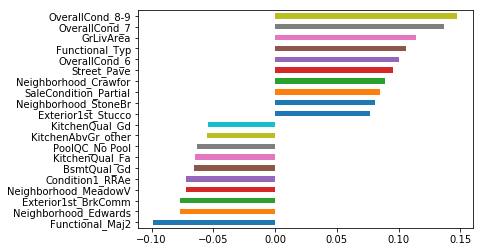

In [89]:
imp_coef_ridge= pd.concat([coef.sort_values().head(10),coef.sort_values().tail(10)])
imp_coef_ridge.plot(kind='barh')

In [90]:
pd.concat([imp_coef_lasso, imp_coef_ridge], axis=1, keys=['Lasso','Ridge'], sort=True).sort_values('Lasso',ascending=False)

,Lasso,Ridge
OverallCond_8-9,0.144080,0.147515
OverallCond_7,0.130143,0.136347
GrLivArea,0.121373,0.114144
SaleCondition_Partial,0.104916,0.084861
Functional_Typ,0.100283,0.105892
Neighborhood_Crawfor,0.098919,0.089251
OverallCond_6,0.091002,0.100540
Neighborhood_NoRidge,0.076348,NaN
Exterior1st_BrkFace,0.076099,NaN
YearBuilt_exp,0.074376,NaN


### (4) ElasticNet

In [91]:
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 100000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 0.1
Best alpha : 0.001


In [92]:
print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 100000, cv = 10)
elasticNet.fit(X_train, y_train)

Now try again for more precision on alpha, with l1_ratio fixed at 0.1 and alpha centered around 0.001


ElasticNetCV(alphas=[0.0006, 0.0006500000000000001, 0.0007, 0.00075, 0.0008, 0.00085, 0.0009000000000000001, 0.00095, 0.001, 0.0010500000000000002, 0.0011, 0.00115, 0.00125, 0.0013000000000000002, 0.00135, 0.0014],
       copy_X=True, cv=10, eps=0.001, fit_intercept=True, l1_ratio=0.1,
       max_iter=100000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [93]:
best_alpha_elasticnet = elasticNet.alpha_
print(f"The best alpha is {best_alpha_elasticnet} and best ratio is {ratio}")

The best alpha is 0.00085 and best ratio is 0.1


 the mean rmse from X_train, y_train is : 0.077
 the mean rmse from X_test, y_test is : 0.100
R2 is:  0.9622321087868889


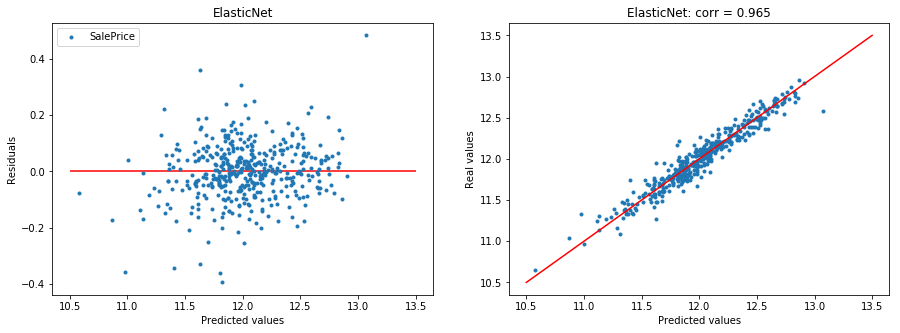

In [102]:
y_train_pred = elasticNet.predict(X_train)
y_test_pred = elasticNet.predict(X_test)


best_rmse_en_train = rmse(y_train, y_train_pred)
best_rmse_en_test = rmse(y_test,y_test_pred)
print(" the mean rmse from X_train, y_train is : %.3f"%best_rmse_en_train)
print(" the mean rmse from X_test, y_test is : %.3f"%best_rmse_en_test)
print("R2 is: ", elasticNet.score(X_train,y_train))

plot_resid_pred(y_test, y_test_pred, "ElasticNet")

In [98]:
coef = pd.Series(elasticNet.coef_, index=X_train.columns)
n_del = str(sum(coef==0))
n_keep = str(sum(coef!=0))

print(f"ElasticNet's best alpha is {best_alpha_ridge}")
print(f"ElasticNet keeps {n_keep} columns and deleted {n_del} columns")

ElasticNet's best alpha is 3.0
ElasticNet keeps 203 columns and deleted 79 columns


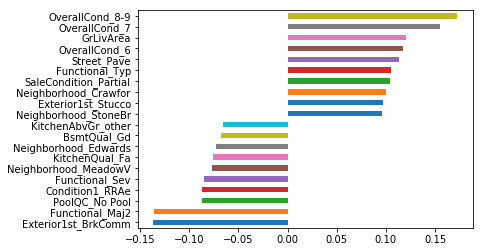

In [99]:
imp_coef_en= pd.concat([coef.sort_values().head(10),coef.sort_values().tail(10)])
imp_coef_en.plot(kind='barh')

In [100]:
pd.concat([imp_coef_lasso, imp_coef_ridge, imp_coef_en], axis=1, keys=['Lasso','Ridge','ElasticNet'], sort=True).sort_values('Lasso',ascending=False)

,Lasso,Ridge,ElasticNet
OverallCond_8-9,0.144080,0.147515,0.172749
OverallCond_7,0.130143,0.136347,0.155166
GrLivArea,0.121373,0.114144,0.119981
SaleCondition_Partial,0.104916,0.084861,0.104508
Functional_Typ,0.100283,0.105892,0.105658
Neighborhood_Crawfor,0.098919,0.089251,0.100502
OverallCond_6,0.091002,0.100540,0.117135
Neighborhood_NoRidge,0.076348,NaN,NaN
Exterior1st_BrkFace,0.076099,NaN,NaN
YearBuilt_exp,0.074376,NaN,NaN


## Now let's include interaction terms for those coefficient survivied in ElasticNet

### Generate interaction terms: X_poly_train and X_poly_test

In [108]:
# Select columns for interaction
bool_cols = [c for c in X_train.columns if X_train[c].nunique() == 2 and coef[c] != 0]
select_cols = [c for c in X_train.columns if X_train[c].nunique()> 2 and coef[c] != 0]

print("There are %d columns can be used to generate interation terms:"%len(select_cols))
print(select_cols)
print("-------------------------------------------------------------------------------")

X_train_inter = X_train[select_cols]
X_test_inter = X_test[select_cols]

print("\nThere are %d boolean cols with coef != 0, below are 3 examples: "%len(bool_cols))
print(bool_cols[:3])

There are 22 columns can be used to generate interation terms:
['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'YearBuilt_exp', 'YearRemodAdd_exp', 'YrSold_exp']
-------------------------------------------------------------------------------

There are 181 boolean cols with coef != 0, below are 3 examples: 
['MSSubClass_SC160', 'MSSubClass_SC180', 'MSSubClass_SC20']


In [111]:
# add interaction terms (x1*x2, but not x1**2) on X_train_inter
poly = PolynomialFeatures(interaction_only=True)
X_poly_train = poly.fit_transform(X_train_inter)
print("X_poly_train's shape: ",X_poly_train.shape)

X_poly_train = pd.DataFrame(X_poly_train,index=y_train.index)

X_poly_train's shape:  (1008, 254)


In [112]:
# add interaction terms (x1*x2, but not x1**2) on X_test_inter
X_poly_test = poly.fit_transform(X_test_inter)
print("X_poly_test's shape: ",X_poly_test.shape)

X_poly_test = pd.DataFrame(X_poly_test,index=y_test.index)

X_poly_test's shape:  (433, 254)


In [113]:
powers = pd.DataFrame(poly.powers_,columns=X_train_inter.columns)
print("powers has shape", powers.shape)
print("we used %d non-boolean features to create %d new features including interactions"%(powers.shape[1],powers.shape[0]))

s = np.where(powers>0, pd.Series(X_train_inter.columns)+', ', '')
print("\ns is an array, it's shape is %s"%str(s.shape))
print(s)

poly_terms = pd.Series([''.join(x).strip() for x in s])
print("\npoly_terms is a Series shwoing terms ")
print(poly_terms)

powers has shape (254, 22)
we used 22 non-boolean features to create 254 new features including interactions

s is an array, it's shape is (254, 22)
[['' '' '' ... '' '' '']
 ['LotFrontage, ' '' '' ... '' '' '']
 ['' 'LotArea, ' '' ... '' '' '']
 ...
 ['' '' '' ... 'YearBuilt_exp, ' 'YearRemodAdd_exp, ' '']
 ['' '' '' ... 'YearBuilt_exp, ' '' 'YrSold_exp, ']
 ['' '' '' ... '' 'YearRemodAdd_exp, ' 'YrSold_exp, ']]

poly_terms is a Series shwoing terms 
0                                      
1                          LotFrontage,
2                              LotArea,
3                          OverallQual,
4                            YearBuilt,
5                         YearRemodAdd,
6                           BsmtFinSF1,
7                            BsmtUnfSF,
8                          TotalBsmtSF,
9                             1stFlrSF,
10                            2ndFlrSF,
11                           GrLivArea,
12                            FullBath,
13                      

### Fit the model using X_poly_train

In [114]:
X_poly_train.columns = poly_terms

In [116]:
print("X_poly_train's shape: ",X_poly_train.shape)
print("y_train's shape: ", y_train.shape)
print("X_poly_test's shape: ", X_poly_test.shape)
print("y_test's shape: ", y_test.shape)

X_poly_train's shape:  (1008, 254)
y_train's shape:  (1008,)
X_poly_test's shape:  (433, 254)
y_test's shape:  (433,)


In [117]:
# fit a new model with the interaction terms
elasticNet = ElasticNetCV(l1_ratio = list(np.arange(0.1,1.0,0.1)),
                          alphas = list(np.arange(1e-4,1e-3,1e-4)), 
                          max_iter = 1000000, cv = 10)
elasticNet.fit(X_poly_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )
poly_coefs = elasticNet.coef_

print('------------------------')
print(sum(poly_coefs==0),'zero coefficients')
print(sum(poly_coefs!=0),'non-zero coefficients')

Best l1_ratio : 0.9
Best alpha : 0.0009000000000000001
------------------------
117 zero coefficients
137 non-zero coefficients


In [118]:
print(len(poly_coefs[(powers.sum(axis=1)==2) & (poly_coefs>0)]),'non-zero interaction terms.')
print('------------------------')
print('Top 30 features with largest coefficients:')
print('------------------------')
print(pd.Series(np.abs(poly_coefs), index=poly_terms).sort_values(ascending=False)[:30])
print('------------------------')

60 non-zero interaction terms.
------------------------
Top 30 features with largest coefficients:
------------------------
GrLivArea,                         0.135261
OverallQual,                       0.102026
TotalBsmtSF,                       0.073541
YearRemodAdd,                      0.052913
BsmtFinSF1,                        0.042340
LotArea,                           0.042041
YearBuilt,                         0.036231
2ndFlrSF, YearBuilt_exp,           0.025299
GarageCars,                        0.025084
GarageYrBlt, GarageArea,           0.023847
OverallQual, TotalBsmtSF,          0.020634
1stFlrSF,                          0.020352
OverallQual, TotRmsAbvGrd,         0.019511
YearBuilt, YearBuilt_exp,          0.017110
YearRemodAdd, YearRemodAdd_exp,    0.016432
FullBath, GarageYrBlt,             0.016378
TotRmsAbvGrd, GarageYrBlt,         0.016173
TotalBsmtSF, BedroomAbvGr,         0.015749
TotRmsAbvGrd, GarageArea,          0.015617
TotRmsAbvGrd, OpenPorchSF,         0.015

 the mean rmse from X_train, y_train is : 0.108
 the mean rmse from X_test, y_test is : 0.124
R2 is:  0.9248158460576175


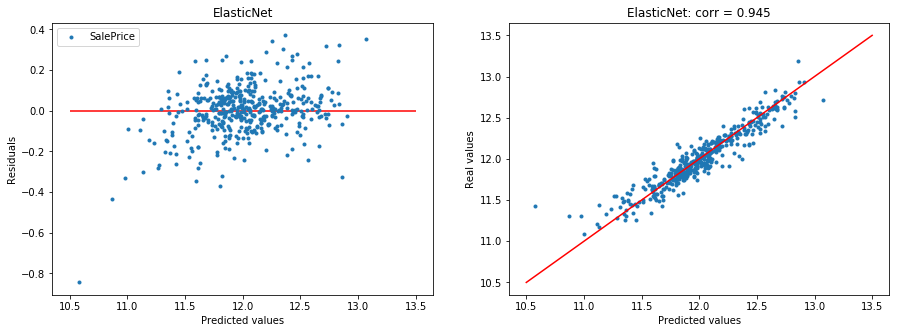

In [121]:
y_train_pred = elasticNet.predict(X_poly_train)
y_test_pred = elasticNet.predict(X_poly_test)

best_rmse_en_inter_train = rmse(y_train, y_train_pred) 
best_rmse_en_inter_test = rmse(y_test, y_test_pred)
print(" the mean rmse from X_train, y_train is : %.3f"%best_rmse_en_inter_train)
print(" the mean rmse from X_test, y_test is : %.3f"%best_rmse_en_inter_test)
print("R2 is: ", elasticNet.score(X_poly_train,y_train))

plot_resid_pred(y_test, y_test_pred, "ElasticNet")

### Find the  top 20 interaction terms with largest coefficients, add them to the original X_train

In [122]:
# add coefficients as a new column into dataframe powers
powers['coef'] = poly_coefs

# sort absolute value of coefficients descendingly
powers_sorted = powers.abs().sort_values('coef',ascending=False)

# For each row in powers_sorted, sum all columns excluding last columns.
# If sum==2, it's an interaction term.
powers_sorted = powers_sorted[powers_sorted.iloc[:,:-1].sum(axis=1)==2]
powers_sorted[:5]

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,YearBuilt_exp,YearRemodAdd_exp,YrSold_exp,coef
185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.025299
227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.023847
68,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020634
74,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019511
98,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.017110


In [123]:
X_poly_train.shape

(1008, 254)

In [124]:
# Set how many interations we want to 
top_n_inter = 30

powers_select = powers_sorted[:top_n_inter]
print(powers_select.shape)

# Loop through each row in powers_select and create the interaction terms into a new dataframe
def create_inter_df(powers, df):
    inter_df = pd.DataFrame(index=df.index)
    
    for idx in powers.index:
        s = powers.loc[idx]
        s = s[s==1]
        term1 = s.index[0]
        term2 = s.index[1]
        inter_df[term1+'_x_'+term2] = minmax_scale(np.multiply(df[term1],df[term2]))
    
    return inter_df 

(30, 23)


In [125]:
# X_train_inter_only has the interaction terms
X_train_inter_only = create_inter_df(powers_select, X_train)
X_test_inter_only = create_inter_df(powers_select, X_test)
print("X_train_inter_only shape: ", X_train_inter_only.shape)
print("X_test_inter_only shape: ", X_test_inter_only.shape)

# append X_train_inter_only to X_train,
X_train_inc_inter = pd.concat([X_train, X_train_inter_only], axis=1)
X_test_inc_inter = pd.concat([X_test, X_test_inter_only], axis=1)
print("X_train_inc_inter shape: ", X_train_inc_inter.shape)
print("X_test_inc_inter shape: ", X_test_inc_inter.shape)

X_train_inter_only shape:  (1008, 30)
X_test_inter_only shape:  (433, 30)
X_train_inc_inter shape:  (1008, 312)
X_test_inc_inter shape:  (433, 312)


### Retrain ElasticNet with X_train_inc_inter 

In [126]:
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train_inc_inter, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 0.1
Best alpha : 0.0006


In [127]:
print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train_inc_inter, y_train)

Now try again for more precision on alpha, with l1_ratio fixed at 0.1 and alpha centered around 0.0006


ElasticNetCV(alphas=[0.00035999999999999997, 0.00039, 0.00041999999999999996, 0.00045, 0.00047999999999999996, 0.0005099999999999999, 0.00054, 0.00057, 0.0006, 0.0006299999999999999, 0.00066, 0.0006899999999999999, 0.0007499999999999999, 0.00078, 0.00081, 0.0008399999999999999],
       copy_X=True, cv=10, eps=0.001, fit_intercept=True, l1_ratio=0.1,
       max_iter=50000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [128]:
best_alpha_elasticnet = elasticNet.alpha_
print(f"The best alpha is {best_alpha_elasticnet} and best ratio is {ratio}")

The best alpha is 0.00078 and best ratio is 0.1


 the mean rmse from X_train, y_train is : 0.073
 the mean rmse from X_test, y_test is : 0.098
R2 is:  0.9652886449114264


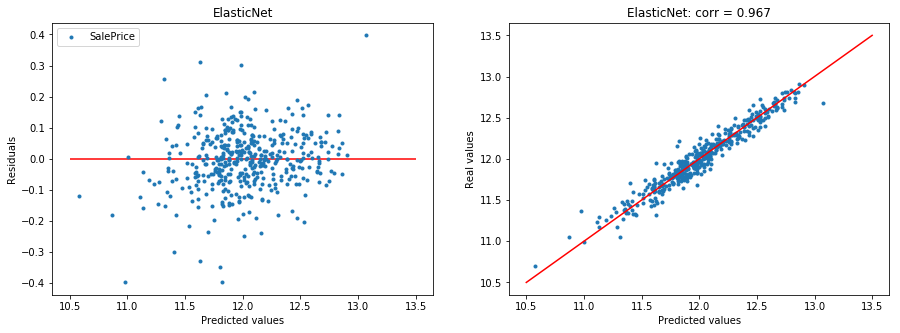

In [132]:
y_train_pred = elasticNet.predict(X_train_inc_inter)
y_test_pred = elasticNet.predict(X_test_inc_inter)

best_rmse_en_inter_train = rmse(y_train, y_train_pred) 
best_rmse_en_inter_test = rmse(y_test, y_test_pred)
print(" the mean rmse from X_train, y_train is : %.3f"%best_rmse_en_inter_train)
print(" the mean rmse from X_test, y_test is : %.3f"%best_rmse_en_inter_test)
print("R2 is: ", elasticNet.score(X_train_inc_inter,y_train))

plot_resid_pred(y_test, y_test_pred, "ElasticNet")

# 4. Generate forecasts

In [138]:
print(X_train_inc_inter.shape)

(1008, 312)


In [137]:
# X_train_inter_only = create_inter_df(powers_select, X_train)

test_proc_inter_only = create_inter_df(powers_select, test_proc)
print(test_proc_inter_only.shape)

(1459, 30)


In [139]:
test_proc_inc_inter = pd.concat([test_proc, test_proc_inter_only], axis=1)
test_proc_inc_inter.shape

(1459, 314)

In [140]:
X = test_proc_inc_inter.drop(['Id','SalePrice'], axis=1)
print(X.shape)

(1459, 312)


In [141]:
y_hat = elasticNet.predict(X)
print(y_hat.shape)

(1459,)


(array([  1.,   0.,   1.,   0.,   1.,   0.,   0.,   3.,   1.,   2.,   5.,
         11.,   2.,  11.,   9.,  15.,  14.,  19.,  33.,  53.,  63.,  74.,
         92., 105., 105., 122.,  97.,  92.,  90.,  95.,  86.,  57.,  49.,
         33.,  26.,  28.,  24.,  14.,  11.,   6.,   2.,   3.,   3.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([10.23462616, 10.29849273, 10.36235929, 10.42622586, 10.49009243,
        10.553959  , 10.61782557, 10.68169214, 10.7455587 , 10.80942527,
        10.87329184, 10.93715841, 11.00102498, 11.06489155, 11.12875811,
        11.19262468, 11.25649125, 11.32035782, 11.38422439, 11.44809096,
        11.51195752, 11.57582409, 11.63969066, 11.70355723, 11.7674238 ,
        11.83129037, 11.89515693, 11.9590235 , 12.02289007, 12.08675664,
        12.15062321, 12.21448978, 12.27835634, 12.34222291, 12.40608948,
        12.46995605, 12.53382262, 12.59768919, 12.66155575, 12.72542232,
        12.78928889, 12.85315546, 12.91702203, 12.9808886 , 13.04475516,
 

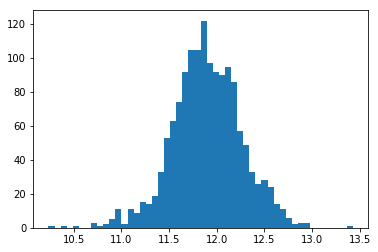

In [144]:
plt.hist(y_hat,bins=50)

(array([  3.,   8.,  25.,  33.,  51., 121., 140., 167., 177., 135., 103.,
        109., 107.,  65.,  54.,  31.,  23.,  17.,  19.,  19.,  12.,  13.,
          6.,   7.,   4.,   1.,   2.,   1.,   1.,   2.,   2.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 27850.0558557 ,  40867.30746982,  53884.55908394,  66901.81069805,
         79919.06231217,  92936.31392628, 105953.5655404 , 118970.81715452,
        131988.06876863, 145005.32038275, 158022.57199686, 171039.82361098,
        184057.0752251 , 197074.32683921, 210091.57845333, 223108.83006745,
        236126.08168156, 249143.33329568, 262160.58490979, 275177.83652391,
        288195.08813803, 301212.33975214, 314229.59136626, 327246.84298037,
        340264.09459449, 353281.34620861, 366298.59782272, 379315.84943684,
        392333.10105095, 405350.35266507, 418367.60427919, 431384.8558933 ,
        444402.10750742, 457419.35912153, 470436.6

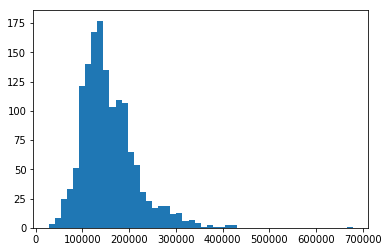

In [145]:
y_hat = np.expm1(y_hat)
plt.hist(y_hat,bins=50)

In [150]:
y_hat_s = pd.DataFrame(y_hat, index=test_proc.index, columns=['SalePrice'])
y_hat_s

,SalePrice
0,113699.559204
1,156342.585315
2,139949.303717
3,166487.539377
4,175837.199566
5,141989.273958
6,137742.118043
7,136225.497340
8,133707.099717
9,105127.169265


In [154]:
submission = pd.concat([test_proc['Id'],y_hat_s],axis=1)
submission.head(4)

,Id,SalePrice
0,1461,113699.559204
1,1462,156342.585315
2,1463,139949.303717
3,1464,166487.539377


In [155]:
submission.to_csv("house_price_submission_v0.csv",index=False)